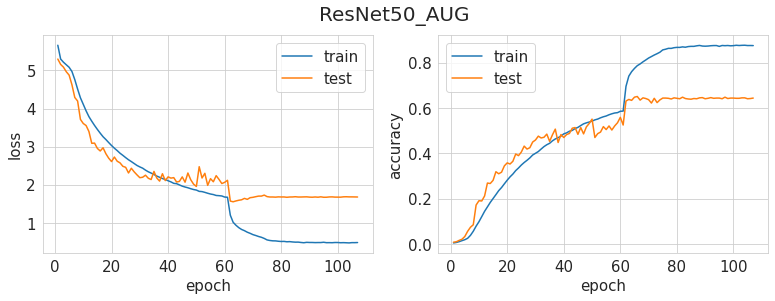

Training 108/200:   0%|          | 0/495 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
#!g1.1

import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm.notebook import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from torchvision.models import resnet50

class MyDataset(Dataset):
    def __init__(self, root, labels, transform = None):
        super().__init__()
        self.labels = labels
        self.transform = transform
        self.all_img = []
        self.all_lab = []

        for ind in tqdm(range(self.labels.shape[0])):
            self.all_img.append(root + self.labels.iloc[ind].Id)
            self.all_lab.append(self.labels.iloc[ind].Label)
        
    def __len__(self):
        return len(self.all_img)

    def __getitem__(self, item):
        image = Image.open(self.all_img[item]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.all_lab[item]
    
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(model_name, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle(model_name, fontsize = 20)
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

labels_val = pd.read_csv("labels_val.csv")
labels_train = pd.read_csv("labels_train.csv")

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomGrayscale(p = 0.25),
    T.RandomHorizontalFlip(p = 0.25),
    T.ToTensor(),
    T.RandomErasing(value = "random", scale = (0.2, 0.4), ratio = (1.0, 1.0)),
    normalize,
])

test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])    

train_dataset = MyDataset(root = "trainval/", labels = labels_train, transform = train_transform)
test_dataset = MyDataset(root = "trainval/", labels = labels_val, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 200, shuffle = True, pin_memory = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = 1000, shuffle = False, pin_memory = True, num_workers = 8)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim = 1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, model_name, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        scheduler.step(test_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(model_name, train_losses, test_losses, train_accuracies, test_accuracies)
        if epoch >= 50 and epoch % 25 == 0:
            torch.save(model, model_name + "_epoch" + str(epoch) + ".pth")

    return train_losses, test_losses, train_accuracies, test_accuracies

model_name = "ResNet50_AUG"
num_epochs = 200
model = resnet50(num_classes = 200)

model.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
model.maxpool = nn.Sequential()
model.fc = nn.Sequential(
    nn.Dropout(inplace = True, p = 0.875),
    nn.Linear(in_features = 2048, out_features = 200, bias = True),
)

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, eps = 0, cooldown = 1)
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, model_name, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

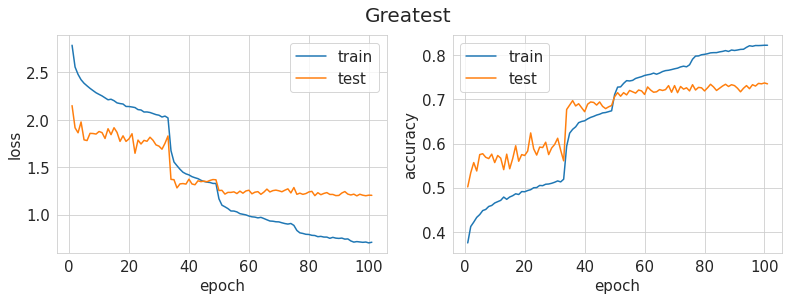

Train loss: 0.7116843076366367
Train accuracy: 0.8222424242424242
Test loss: 1.2059650421142578
Test accuracy: 0.735


Training 102/200:   0%|          | 0/330 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
#!g1.1

import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm.notebook import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root, labels, transform = None):
        super().__init__()
        self.labels = labels
        self.transform = transform
        self.all_img = []
        self.all_lab = []

        for ind in tqdm(range(self.labels.shape[0])):
            self.all_img.append(root + self.labels.iloc[ind].Id)
            self.all_lab.append(self.labels.iloc[ind].Label)
        
    def __len__(self):
        return len(self.all_img)

    def __getitem__(self, item):
        image = Image.open(self.all_img[item]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.all_lab[item]
    
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(model_name, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle(model_name, fontsize = 20)
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

labels_val = pd.read_csv("labels_val.csv")
labels_train = pd.read_csv("labels_train.csv")

normalize = T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomHorizontalFlip(p = 0.25),
    T.RandomVerticalFlip(p = 0.25),
    T.RandAugment(num_ops = 3),
    T.ToTensor(),
    T.RandomErasing(value = "random", scale = (0.2, 0.4), ratio = (1.0, 1.0)),
    normalize,
])

test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])    

train_dataset = MyDataset(root ="trainval/", labels = labels_train, transform = train_transform)
test_dataset = MyDataset(root ="trainval/", labels = labels_val, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 300, shuffle = True, pin_memory = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = 1000, shuffle = False, pin_memory = True, num_workers = 8)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim = 1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, model_name, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        scheduler.step(test_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(model_name, train_losses, test_losses, train_accuracies, test_accuracies)
        print("Train loss:", train_loss)
        print("Train accuracy:", train_accuracy)
        print("Test loss:", test_loss)
        print("Test accuracy:", test_accuracy)
        
        if epoch % 25 == 0:
            torch.save(model, model_name + "_epoch" + str(epoch) + ".pth")

model_name = "Greatest"
num_epochs = 200
model = torch.load("ResNet50_AUG_epoch75.pth")
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, eps = 0, cooldown = 5, factor = 0.3)
train(
    model, model_name, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [13]:
#!g1.1
import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm.notebook import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, root, transform = None):
        super().__init__()
        self.transform = transform
        self.all_img = []

        for ind in tqdm(range(10000)):
            self.all_img.append(root + "test_" + f'{ind:05}' + ".jpg")
        
    def __len__(self):
        return len(self.all_img)

    def __getitem__(self, item):
        image = Image.open(self.all_img[item]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.all_img[item]

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])  

test_dataset = TestDataset(root = "test/", transform = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = False, pin_memory = True, num_workers = 8)

ans = pd.DataFrame(columns = ["Id", "Label"])

def test_epoch(model, test_loader, df):
    model.eval()
    for images, items in tqdm(test_loader):
        images = images.to('cuda:0')  # images: batch_size x num_channels x height x width
        logits = model(images)  # logits: batch_size x num_classes
        
        for item, logit in zip(items, logits.argmax(dim = 1)):
            df.loc[item[-14:]] = [item[-14:], logit.item()]

model = torch.load("Greatest_epoch100.pth")

test_epoch(model, test_loader, ans)
ans.to_csv("32_try.csv", index = False)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]